In [48]:
import pandas as pd
import numpy as np

import keras

import matplotlib.pyplot as plt

### Dealing with shitty file format

In [ ]:
# index = [i for i in range(35887)]

# columns = ['y'] + [str(i) for i in range(48 * 48)] + ['category']

# df = pd.DataFrame(columns=columns, index = index)

# with open('../data/emotions/fer2013/fer2013.csv') as file:
#     file.readline()
    
#     for i in range(35887):
#         print(i)
#         line = file.readline()
        
#         y, pixels, category = line.split(',')
        
#         pixels = [p for p in pixels.split(' ')]
        
#         df.at[i, 'y'] = y
        
#         for index, value in enumerate(pixels):
#             df.at[i, str(index)] = value
            
#         df.at[i, 'category'] = category

# df.to_csv('../data/emotions/emotions.csv')

In [2]:
df = pd.read_csv('../data/emotions/emotions.csv')

In [4]:
df['category'] = df['category'].str.strip()

In [6]:
df.shape

(35887, 2307)

In [7]:
train = df.loc[df.category == 'Training',:]
valid = df.loc[df.category == 'PublicTest',:]
test  = df.loc[df.category == 'PrivateTest',:]

In [9]:
train.head(1)

,Unnamed: 0,y,0,1,2,3,4,5,6,7,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,category
0,0,0,70,80,82,72,58,58,60,63,...,182,183,136,106,116,95,106,109,82,Training


In [16]:
X_train = np.array(train.iloc[:, 2:2306])
y_train = np.array(train.loc[:, ['y']])

print(X_train.shape)
print(y_train.shape)

(28709, 2304)
(28709, 1)


In [17]:
X_val = np.array(valid.iloc[:, 2:2306])
y_val = np.array(valid.loc[:, ['y']])

print(X_val.shape)
print(y_val.shape)

(3589, 2304)
(3589, 1)


In [57]:
X_test = np.array(test.iloc[:, 2:2306])
y_test = np.array(test.loc[:, ['y']])

print(X_test.shape)
print(y_test.shape)

(3589, 2304)
(3589, 1)


In [35]:
mapping = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'   
}

### Watch some random images

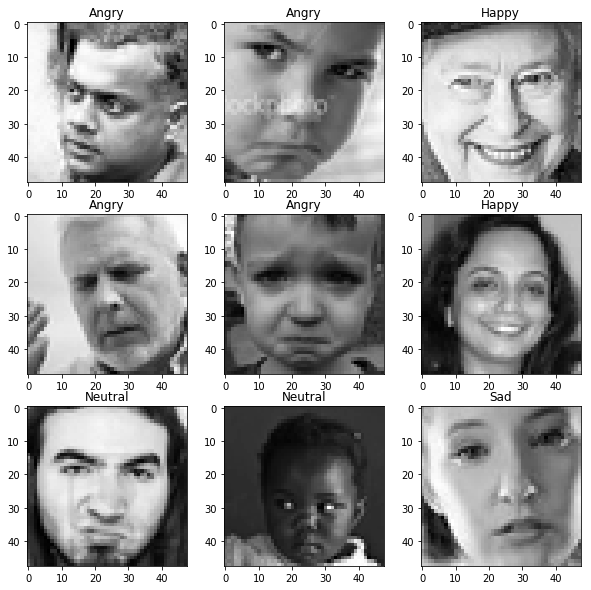

In [46]:
fig = plt.figure(figsize=(10, 10))

rows = 3
cols = 3

for i in range(1, rows * cols + 1):
    idx = np.random.randint(1, len(X_train))
    
    fig.add_subplot(rows, cols, i)
    plt.imshow(X_train[idx].reshape((48,48)), cmap = 'gray')
    plt.title(mapping[y_train[idx][0]])
plt.show()

In [50]:
y_train = keras.utils.to_categorical(y_train, 7)

In [53]:
y_train.shape

(28709, 7)

In [54]:
y_val = keras.utils.to_categorical(y_val, 7)
y_val.shape

(3589, 7)

In [58]:
y_test = keras.utils.to_categorical(y_test, 7)
y_test.shape

(3589, 7)

### Alexnet CNN architecture

In [177]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import optimizers

from keras.models import model_from_json

from keras.metrics import categorical_accuracy

np.random.seed(100)

In [70]:
X_train_r = X_train.reshape((len(X_train), 48, 48, 1))
X_val_r   = X_val.reshape((len(X_val), 48, 48, 1))

In [86]:
X_train_r = X_train_r / 255

In [88]:
X_val_r = X_val_r / 255

In [194]:
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])

In [181]:
model.load_weights('../models/weights/complex_20_cc.h5')

In [182]:
model.fit(X_train_r, y_train, batch_size=32, epochs=3, validation_data=(X_val_r, y_val))

Train on 28709 samples, validate on 3589 samples
Epoch 1/3
28709/28709 [==============================] - 1270s 44ms/step - loss: 0.2413 - categorical_accuracy: 0.9145 - val_loss: 1.7545 - val_categorical_accuracy: 0.6119
Epoch 2/3
28709/28709 [==============================] - 1156s 40ms/step - loss: 0.2483 - categorical_accuracy: 0.9121 - val_loss: 1.5555 - val_categorical_accuracy: 0.6152
Epoch 3/3
28709/28709 [==============================] - 1145s 40ms/step - loss: 0.2404 - categorical_accuracy: 0.9157 - val_loss: 1.4941 - val_categorical_accuracy: 0.6247


In [187]:
model.save_weights('../models/weights/complex_20_cc_2.h5')

In [115]:
X_test_r   = X_test.reshape((len(X_test), 48, 48, 1))

In [195]:
model_json = model.to_json()

In [196]:
with open("../models/model_deep.json", "w") as json_file:
    json_file.write(model_json)

In [197]:
def read_model_from_disk(model: str, weights: str):
    
    json_file = open(model, 'r')
    
    loaded_model = json_file.read()
    
    model = model_from_json(loaded_model)
    
    model.load_weights(weights)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])
    
    return model

In [198]:
model_saved = read_model_from_disk(model='../models/model_deep.json', weights='../models/weights/complex_20_cc_2.h5')

### Evaluations

In [185]:
X_test_r = X_test_r / 255

In [199]:
model_saved.evaluate(X_test_r, y = y_test, verbose=1)

3589/3589 [==============================] - 41s 12ms/step


[1.4520415713708026, 0.632488158269658]

### Experiments

In [202]:
X_test_r.shape

(3589, 48, 48, 1)

In [203]:
import cv2 as cv

In [204]:
image = cv.imread('../scripts/tmp/faces/1_0.png',  cv.IMREAD_GRAYSCALE)

In [207]:
train.loc[0, 'category']

'Training'